<a href="https://colab.research.google.com/github/sppandlkk/healthcare-nlp-llm-pipelines/blob/main/notebooks/01_deid_clinical_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install transformers[sentencepiece]
!pip install presidio-analyzer presidio-anonymizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.19.0
    Uninstalling textblob-0.19.0:
      Successfully uninstalled textblob-0.19.0


In [88]:
import pandas as pd
from transformers import pipeline
from presidio_analyzer import AnalyzerEngine, RecognizerResult
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# create synthetic notes. Notice that I have NurseKate (missing space) to tell whether model can flag it
note_text = """
Patient Emma Su underwent inpatient surgery for acute exacerbation of asthma and was admitted to the hospital for further management. During her stay, she received treatment with IV steroids, bronchodilators, and oxygen therapy. She was also seen by Dr. Lee, a pulmonologist, who adjusted her medication regimen. The patient's family members, including Rob (brother), Liv, and Dave (partner), visited her regularly and provided emotional support. The dad (Pete) expressed concern about her condition and stated "I'm glad she's getting the care she needs, sweetie". Her mom, Jen K, will be picking her up from the hospital today after discharge. During her stay, the patient underwent various tests, including pulmonary function tests and chest X-rays, which showed significant improvement after treatment. The patient was also educated on proper inhaler use and asthma management by NurseKate. She will follow up with Dr. Smith in 2 weeks to reassess her symptoms and adjust her medication regimen as needed. Her friend mike will be helping her with errands and chores during her recovery. The patient's condition improved significantly during her stay, and she was discharged in stable condition with instructions to rest and continue her medication regimen. Emma's condition will continue to be monitored by her healthcare team, including Dr. Smith Y. and Nurse Kate W. Documented by: Kate Whittier. Signed by: Dr. Smith Yeats. Date: March 15, 2023, 14:30
"""
note_text

'\nPatient Emma Su underwent inpatient surgery for acute exacerbation of asthma and was admitted to the hospital for further management. During her stay, she received treatment with IV steroids, bronchodilators, and oxygen therapy. She was also seen by Dr. Lee, a pulmonologist, who adjusted her medication regimen. The patient\'s family members, including Rob (brother), Liv, and Dave (partner), visited her regularly and provided emotional support. The dad (Pete) expressed concern about her condition and stated "I\'m glad she\'s getting the care she needs, sweetie". Her mom, Jen K, will be picking her up from the hospital today after discharge. During her stay, the patient underwent various tests, including pulmonary function tests and chest X-rays, which showed significant improvement after treatment. The patient was also educated on proper inhaler use and asthma management by NurseKate. She will follow up with Dr. Smith in 2 weeks to reassess her symptoms and adjust her medication regi

In [85]:
# initialize presidio_analyzer
analyzer = AnalyzerEngine()
# detect PII
results = analyzer.analyze(text=note_text, entities=["PERSON"], language="en")

df_presidio = pd.DataFrame([
    {
        "model": "presidio",
        "entity_type": ent.entity_type,
        "entity_start_index": ent.start,
        "entity_end_index": ent.end,
        "entity_text": note_text[ent.start:ent.end]
    } for ent in results
])
df_presidio.head()

,model,entity_type,entity_start_index,entity_end_index,entity_text
0,presidio,PERSON,9,16,Emma Su
1,presidio,PERSON,255,258,Lee
2,presidio,PERSON,354,357,Rob
3,presidio,PERSON,369,372,Liv
4,presidio,PERSON,378,382,Dave


In [91]:
# Use a small NER model for demo
bert_base = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
ents = bert_base(note_text)
df_bert_base = pd.DataFrame([
    {
        "model": "bert_base",
        "entity_type": ent["entity_group"],
        "entity_start_index": ent["start"],
        "entity_end_index": ent["end"],
        "entity_text": ent["word"]
    } for ent in ents
])
df_bert_base.head()

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


,model,entity_type,entity_start_index,entity_end_index,entity_text
0,bert_base,PER,9,16,Emma Su
1,bert_base,PER,255,258,Lee
2,bert_base,PER,354,357,Rob
3,bert_base,PER,369,372,Liv
4,bert_base,PER,378,382,Dave


In [83]:
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Build NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
# Run NER
ents = ner_pipeline(note_text)

df_bert_finetuned = pd.DataFrame([
    {
        "model": "bert_finetuned",
        "entity_type": ent["entity_group"],
        "entity_start_index": ent["start"],
        "entity_end_index": ent["end"],
        "entity_text": ent["word"]
    } for ent in ents
])
df_bert_finetuned.head()


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


,model,entity_type,entity_start_index,entity_end_index,entity_text
0,bert_finetuned,PER,9,16,Emma Su
1,bert_finetuned,PER,255,258,Lee
2,bert_finetuned,PER,354,357,Rob
3,bert_finetuned,PER,369,372,Liv
4,bert_finetuned,PER,378,382,Dave
5,bert_finetuned,PER,457,461,Pete
6,bert_finetuned,PER,575,580,Jen K
7,bert_finetuned,ORG,884,893,NurseKate
8,bert_finetuned,PER,923,928,Smith
9,bert_finetuned,PER,1261,1265,Emma


In [139]:
# manually annotate entity_text
ground_truth = pd.DataFrame(
    {
    "entity_text": ["Emma Su", "Lee", "Rob", "Liv", "Dave", "Pete", "Jen K", "Kate", "Smith", "mike", "Emma", "Smith Y.", "Kate W.", "Kate Whittier", "Smith Yeats"],
    "entity_start_index": [9, 255, 354, 369, 378, 457, 575, 889, 923, 1021, 1261, 1346, 1365, 1388, 1418],
    "entity_end_index": [16, 258, 357, 372, 382, 461, 580, 893, 928, 1025, 1265, 1354, 1372, 1401, 1429]
})
ground_truth

,entity_text,entity_start_index,entity_end_index
0,Emma Su,9,16
1,Lee,255,258
2,Rob,354,357
3,Liv,369,372
4,Dave,378,382
5,Pete,457,461
6,Jen K,575,580
7,Kate,889,893
8,Smith,923,928
9,mike,1021,1025


In [146]:
def evaluate_ner_models(ground_truth, model_dfs, model_names, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5]):
    """
    Evaluate multiple NER models against ground truth using overlap-based matching.

    Parameters
    ----------
    ground_truth : pd.DataFrame
        DataFrame containing ground truth entities with columns:
        ['entity_text', 'entity_start_index', 'entity_end_index'].
    model_dfs : list of pd.DataFrame
        List of predicted entities DataFrames, each with the same columns as ground_truth.
    model_names : list of str
        Names of the models corresponding to model_dfs.
    thresholds : list of float, optional
        Minimum overlap ratio to consider a predicted entity as a true positive.

    Returns
    -------
    pd.DataFrame
        DataFrame containing precision and recall for each model at each threshold.
        Columns: ['model', 'threshold', 'precision', 'recall'].
    """
    results = []

    for model_df, model_name in zip(model_dfs, model_names):
        for t in thresholds:
            tp, fp, fn = 0, 0, 0
            matched_gt_idx = set()

            # Iterate over predicted entities
            for _, m_row in model_df.iterrows():
                m_start, m_end = m_row['entity_start_index'], m_row['entity_end_index']
                match_found = False

                for gt_idx, gt_row in ground_truth.iterrows():
                    gt_start, gt_end = gt_row['entity_start_index'], gt_row['entity_end_index']

                    # Compute overlap
                    overlap = max(0, min(m_end, gt_end) - max(m_start, gt_start))
                    overlap_ratio = overlap / (gt_end - gt_start)

                    if overlap_ratio >= t:
                        tp += 1
                        matched_gt_idx.add(gt_idx)
                        match_found = True
                        break

                if not match_found:
                    fp += 1

            fn = len(ground_truth) - len(matched_gt_idx)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            results.append({
                'model': model_name,
                'threshold': t,
                'precision': precision,
                'recall': recall
            })

    results_df = pd.DataFrame(results)
    return results_df

In [147]:
evaluation_result = \
evaluate_ner_models(ground_truth,
                    model_dfs=[df_presidio, df_bert_base, df_bert_finetuned],
                    model_names=["Presidio", "BERT Base", "BERT Finetuned"],
                    thresholds = [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
evaluation_result

,model,threshold,precision,recall
0,Presidio,0.1,1.000000,0.933333
1,Presidio,0.4,1.000000,0.933333
2,Presidio,0.5,0.928571,0.866667
3,Presidio,0.6,0.928571,0.866667
4,Presidio,0.7,0.928571,0.866667
5,Presidio,0.8,0.928571,0.866667
6,Presidio,0.9,0.928571,0.866667
7,Presidio,1.0,0.928571,0.866667
8,BERT Base,0.1,0.875000,0.933333
9,BERT Base,0.4,0.812500,0.866667


In [151]:
def plot_ner_score(results_df, metric='precision'):
    """
    Plot NER evaluation score for multiple models across thresholds.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame from evaluate_ner_models containing columns:
        ['model', 'threshold', 'precision', 'recall'].
    metric : str, optional
        Metric to plot. Must be either 'precision' or 'recall'.

    Returns
    -------
    None
        Displays a line plot for the selected metric.
    """
    if metric not in ['precision', 'recall']:
        raise ValueError("metric must be 'precision' or 'recall'")

    plt.figure(figsize=(10,6))
    sns.lineplot(data=results_df, x='threshold', y=metric, hue='model', marker='o')
    plt.ylim(0,1.1)
    plt.title(f"NER Model Evaluation: {metric.capitalize()} vs Threshold")
    plt.xlabel("Overlap Threshold")
    plt.ylabel(metric.capitalize())
    plt.show()

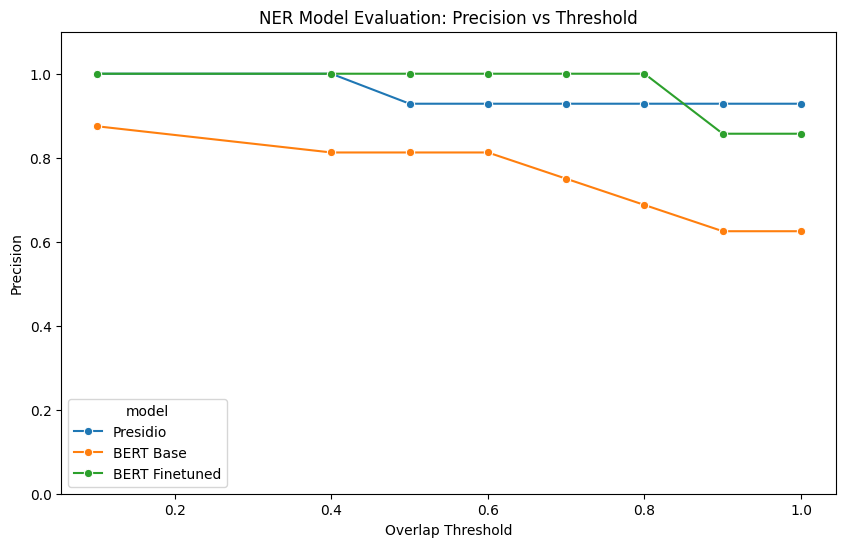

In [152]:
plot_ner_score(evaluation_result, "precision")

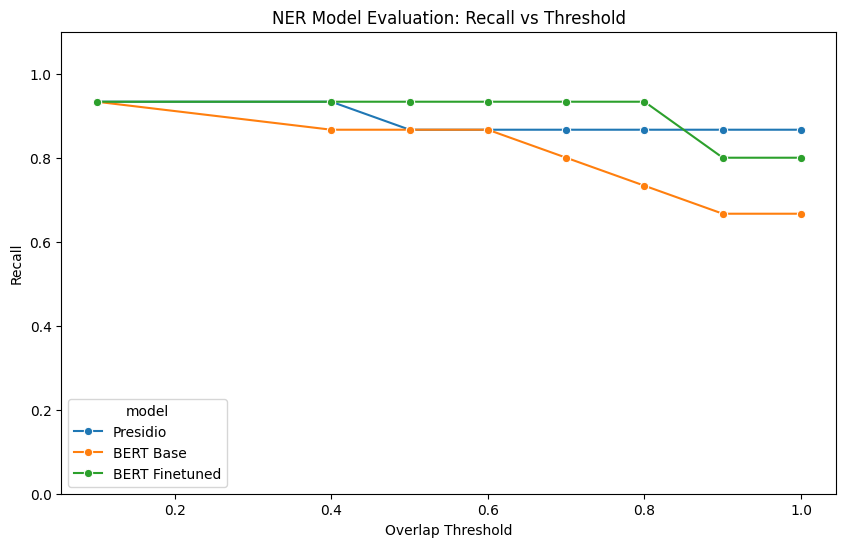

In [153]:
plot_ner_score(evaluation_result, "recall")

In [143]:
df_presidio

,model,entity_type,entity_start_index,entity_end_index,entity_text
0,presidio,PERSON,9,16,Emma Su
1,presidio,PERSON,255,258,Lee
2,presidio,PERSON,354,357,Rob
3,presidio,PERSON,369,372,Liv
4,presidio,PERSON,378,382,Dave
5,presidio,PERSON,457,461,Pete
6,presidio,PERSON,575,580,Jen K
7,presidio,PERSON,923,928,Smith
8,presidio,PERSON,1021,1025,mike
9,presidio,PERSON,1261,1265,Emma


In [144]:
ground_truth

,entity_text,entity_start_index,entity_end_index
0,Emma Su,9,16
1,Lee,255,258
2,Rob,354,357
3,Liv,369,372
4,Dave,378,382
5,Pete,457,461
6,Jen K,575,580
7,Kate,889,893
8,Smith,923,928
9,mike,1021,1025
